In [9]:
# general
import boto3
import datetime as dt
import json
import numpy as np
import pandas as pd
import snowflake.connector

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

## 1. "The Northman" Does not have viewership data --- 26 titls in total missing that

### 0.2 : Connection to Snowflake

In [9]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

datascience-max-dev-sagemaker-notebooks


In [24]:
get_secret_value_response

{'ARN': 'arn:aws:secretsmanager:us-east-1:613630599026:secret:datascience-max-dev-sagemaker-notebooks-6P450a',
 'Name': 'datascience-max-dev-sagemaker-notebooks',
 'VersionId': 'c7acdf78-4842-4a9e-840b-9823979d9ceb',
 'SecretString': '{"login_name":"max.glue.dev","login_password":"2p6R3teB8wm@9G","warehouse":"MAX_DATASCIENCE_DEV","role":"MAX_GLUE_DEV","snowflake_url":"https://hbomax.us-east-1.snowflakecomputing.com/","account":"hbomax.us-east-1"}',
 'VersionStages': ['AWSCURRENT'],
 'CreatedDate': datetime.datetime(2021, 3, 24, 5, 43, 21, 52000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'b83aade1-13af-4408-8561-ace790e3d39f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b83aade1-13af-4408-8561-ace790e3d39f',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '528',
   'date': 'Thu, 15 Feb 2024 00:40:49 GMT'},
  'RetryAttempts': 0}}

In [5]:
original_movies = pd.read_csv('Pay-1 Titles Theatrical Window_v0.2.csv')

In [6]:
original_movies.head()

,Title Name,Hbomax Title ID,Reporting Content Category,Net Studio,Wbd Max Content Category,Reporting Primary Genre,Title First Offered Date
0,5000 Blankets,GZK1izABA6sNYwwEAAACn,Pay 1,Other 3rd Party,Movie,Drama,2023-08-18
1,65,GZGUWBgT7UMN_dwEAAApT,Pay 1,Sony / Columbia,Movie,Fantasy & Sci-Fi,2023-06-16
2,A Man Called Otto,GZDZ4jASL83SfmgEAAAdO,Pay 1,Sony / Columbia,Movie,Comedy,2023-05-12
3,Amor Bandido,GY9cisQTgx7iWtQEAAAAf,Pay 1,Other 3rd Party,Movie,drama,2023-02-24
4,"Are You There God? It's Me, Margaret.",GZTACwwALO8JMRAEAABM9,Pay 1,Sony / Columbia,Movie,Comedy,2023-11-10


In [7]:
len(original_movies)

62

In [8]:
title_info = run_query('''
SELECT m.TITLE_SERIES, m.LEGACY_SERIES_ID, m.CKG_SERIES_ID, m.FIRST_RELEASE_DATE, o.start_date AS THEATRICAL_DATE
, PROGRAM_TYPE, PRIMARY_GENRE, LATAM_HOME_MEDAL
, O.TITLE_ID as imdb_id, c.AREA_NAME, m.GEO_VALUE, o.area_gross ,bdg.AMOUNT as budget
FROM max_prod.content_datascience.all_titles_season_metadata m
JOIN max_prod.ckg.imdb_boxoffice_opening_weekends o 
    ON m.imdb_series_id = o.title_id
JOIN MAX_PROD.CKG.IMDB_AREA_CODES c 
    ON c.AREA_CODE= o.AREA_CODE and UPPER(c.AREA_NAME) = m.GEO_VALUE
left join "MAX_PROD"."CKG".IMDB_BOXOFFICE_TITLE_BUDGET bdg -- budget title_id to imdb_id
    on m.imdb_series_id=bdg.title_id
WHERE m.GEO_VALUE IN ('LATAM', 'BRAZIL', 'ARGENTINA', 'COLOMBIA', 'MEXICO', 'CARIBBEAN', 'REST OF LATAM')
and m.ever_pay_1_title = 1
order by title_series, area_name
''')

In [9]:
title_info.head()

,title_series,legacy_series_id,ckg_series_id,first_release_date,theatrical_date,program_type,primary_genre,latam_home_medal,imdb_id,area_name,geo_value,area_gross,budget
0,65,GZGUWBgT7UMN_dwEAAApT,3d467c4e-90f7-4e71-b226-f4a8e1e97c40,2023-06-15,2023-03-09,Acquired,Action,Gold,tt12261776,Colombia,COLOMBIA,"160,117.00","45,000,000.00"
1,65,GZGUWBgT7UMN_dwEAAApT,3d467c4e-90f7-4e71-b226-f4a8e1e97c40,2023-06-15,2023-03-10,Acquired,Action,Gold,tt12261776,Mexico,MEXICO,"1,048,370.00","45,000,000.00"
2,A Man Called Otto,GZDZ4jASL83SfmgEAAAdO,266e3ad8-d836-47c9-99cd-4648c2e86c60,2023-05-11,2023-01-12,Acquired,Drama,Silver,tt7405458,Colombia,COLOMBIA,"57,910.00","50,000,000.00"
3,A Man Called Otto,GZDZ4jASL83SfmgEAAAdO,266e3ad8-d836-47c9-99cd-4648c2e86c60,2023-05-11,2022-12-23,Acquired,Drama,Silver,tt7405458,Mexico,MEXICO,"294,207.00","50,000,000.00"
4,Ambulance,GYyRIgQNLUhu1wwEAAAAF,GYyRIgQNLUhu1wwEAAAAF,2022-11-24,2022-03-17,Acquired,Action,None,tt4998632,Argentina,ARGENTINA,"64,000.00","40,000,000.00"


In [10]:
len(title_info.legacy_series_id.unique())

97

In [11]:
len(title_info)

222

In [12]:
# title_info['latam_home_medal'] = title_info['latam_home_medal'].replace('No Medal', np.NaN)

# title_info['latam_home_medal'] = title_info.groupby(['ckg_series_id'])['latam_home_medal'].bfill()
# title_info['latam_home_medal'] = title_info.groupby(['ckg_series_id'])['latam_home_medal'].ffill()

# title_info['latam_home_medal'] = title_info['latam_home_medal'].fillna('None')

In [13]:
area_gross = title_info.groupby(['ckg_series_id'])['area_gross'].sum().reset_index()
budget = title_info.groupby(['ckg_series_id'])['budget'].first().reset_index()

In [14]:
title_info = title_info.groupby(['title_series', 'legacy_series_id', 'ckg_series_id', 'imdb_id', 'program_type', 
                                 'primary_genre', 'first_release_date'])['theatrical_date'].first().reset_index()

In [15]:
title_info = title_info.merge(area_gross, on = ['ckg_series_id'], how = 'left')\
                       .merge(budget, on = ['ckg_series_id'], how = 'left')

In [16]:
title_info.head()

,title_series,legacy_series_id,ckg_series_id,imdb_id,program_type,primary_genre,first_release_date,theatrical_date,area_gross,budget
0,65,GZGUWBgT7UMN_dwEAAApT,3d467c4e-90f7-4e71-b226-f4a8e1e97c40,tt12261776,Acquired,Action,2023-06-15,2023-03-09,"1,208,487.00","45,000,000.00"
1,A Man Called Otto,GZDZ4jASL83SfmgEAAAdO,266e3ad8-d836-47c9-99cd-4648c2e86c60,tt7405458,Acquired,Drama,2023-05-11,2023-01-12,"352,117.00","50,000,000.00"
2,Ambulance,GYyRIgQNLUhu1wwEAAAAF,GYyRIgQNLUhu1wwEAAAAF,tt4998632,Acquired,Action,2022-11-24,2022-03-17,"1,218,886.00","40,000,000.00"
3,Armageddon Time,GZK1nDg0nFaXCwgEAABAp,1e047963-2433-4a1a-8095-830022a0ce57,tt10343028,Acquired,Drama,2023-08-10,2023-03-16,"3,967.00","15,000,000.00"
4,Asteroid City,GZa6EDAQ-Y5aQVgEAACX0,GZa6EDAQ-Y5aQVgEAACX0,tt14230388,Acquired,Comedy,2024-02-15,2023-08-10,"285,952.00","25,000,000.00"


In [17]:
len(title_info)

97

In [18]:
# title_info.to_csv('latam_title_release_info.csv')

In [19]:
medal= run_query('''
WITH TEMP AS (
select
WBD_MAX_SERIES_ID_OR_HBOMAX_TITLE_ID AS ckg_series_id, DAYS_ON_HBO_MAX_AND_WBD_MAX as day_on_max,
OFFERING_START_DATE_PST, REQUEST_DATE_PST,  DAYS_ON_HBO_MAX_AND_WBD_MAX, 
c.CUMULATIVE_VIEWING_SUBSCRIBERS/plt.viewing_subscribers*100 as percent_cumulative_viewing_subscribers,
       c.CUMULATIVE_SUBSCRIPTION_FIRST_VIEWS/plt.subscription_first_views*100 as percent_cumulative_first_views
from max_prod.content_analytics.cumulative_content_viewership_pst  c
JOIN max_prod.content_analytics.cumulative_platform_viewership_pst plt
ON to_char(c.OFFERING_START_DATE_PST, 'YYYY-MM-DD') = plt.start_date
AND c.DAYS_ON_HBO_MAX_AND_WBD_MAX = plt.DAYS_SINCE_RELEASE
AND c.GEO_VALUE = plt.GEO_VALUE
where c.geo_value = 'LATAM' 
and day_on_max = 28
and title_level = 'Seasons and Movies'
and OFFERING_WINDOW_NUM = 1
order by DAYS_ON_HBO_MAX_AND_WBD_MAX
)

SELECT ckg_series_id,
    case when percent_cumulative_viewing_subscribers > 20 or percent_cumulative_first_views > 10 then 'Platinum'
		 when percent_cumulative_viewing_subscribers > 10 or percent_cumulative_first_views > 5 then 'Gold'
		 when percent_cumulative_viewing_subscribers > 5 or percent_cumulative_first_views > 2.5 then 'Silver'
		 else 'Bronze'
		 end as observed_medal
FROM TEMP
''')

In [20]:
title_info = title_info.merge(medal, on = ['ckg_series_id'], how = 'left')

In [21]:
# title_info.loc[title_info['latam_home_medal'] == 'None', 'latam_home_medal'] = title_info['observed_medal']
title_info['latam_home_medal'] = title_info['observed_medal']

In [22]:
# final_title_info = title_info[title_info['observed_medal'].notnull()]

In [23]:
len(title_info)

97

In [24]:
viewership = run_query('''
select
WBD_MAX_SERIES_ID_OR_HBOMAX_TITLE_ID AS ckg_series_id, DAYS_ON_HBO_MAX_AND_WBD_MAX as day_on_max,
c.CUMULATIVE_VIEWING_SUBSCRIBERS, c.CUMULATIVE_SUBSCRIPTION_FIRST_VIEWS as CUMULATIVE_FIRST_VIEWS,
c.CUMULATIVE_VIEWING_SUBSCRIBERS/plt.viewing_subscribers*100 as percent_cumulative_viewing_subscribers,
c.CUMULATIVE_SUBSCRIPTION_FIRST_VIEWS/plt.subscription_first_views*100 as percent_cumulative_first_views
from max_prod.content_analytics.cumulative_content_viewership_pst  c
JOIN max_prod.content_analytics.cumulative_platform_viewership_pst plt
ON to_char(c.OFFERING_START_DATE_PST, 'YYYY-MM-DD') = plt.start_date
AND c.DAYS_ON_HBO_MAX_AND_WBD_MAX = plt.DAYS_SINCE_RELEASE
AND c.GEO_VALUE = plt.GEO_VALUE
where c.geo_value = 'LATAM' 
and title_level = 'Seasons and Movies'
and OFFERING_WINDOW_NUM = 1
and DAYS_ON_HBO_MAX_AND_WBD_MAX = 90
order by DAYS_ON_HBO_MAX_AND_WBD_MAX
''')

In [25]:
title_info = title_info.merge(viewership, on = ['ckg_series_id'], how = 'left')

In [26]:
len(title_info.legacy_series_id.unique())

97

In [27]:
title_info.head()

,title_series,legacy_series_id,ckg_series_id,imdb_id,program_type,primary_genre,first_release_date,theatrical_date,area_gross,budget,observed_medal,latam_home_medal,day_on_max,cumulative_viewing_subscribers,cumulative_first_views,percent_cumulative_viewing_subscribers,percent_cumulative_first_views
0,65,GZGUWBgT7UMN_dwEAAApT,3d467c4e-90f7-4e71-b226-f4a8e1e97c40,tt12261776,Acquired,Action,2023-06-15,2023-03-09,"1,208,487.00","45,000,000.00",NaN,NaN,90.00,0.00,"2,593.00",0.000000,0.099100
1,A Man Called Otto,GZDZ4jASL83SfmgEAAAdO,266e3ad8-d836-47c9-99cd-4648c2e86c60,tt7405458,Acquired,Drama,2023-05-11,2023-01-12,"352,117.00","50,000,000.00",NaN,NaN,nan,nan,nan,NaN,NaN
2,Ambulance,GYyRIgQNLUhu1wwEAAAAF,GYyRIgQNLUhu1wwEAAAAF,tt4998632,Acquired,Action,2022-11-24,2022-03-17,"1,218,886.00","40,000,000.00",Silver,Silver,90.00,"1,107,532.00","7,058.00",8.839600,0.199500
3,Armageddon Time,GZK1nDg0nFaXCwgEAABAp,1e047963-2433-4a1a-8095-830022a0ce57,tt10343028,Acquired,Drama,2023-08-10,2023-03-16,"3,967.00","15,000,000.00",Bronze,Bronze,90.00,"34,968.00",226.00,0.295300,0.008600
4,Asteroid City,GZa6EDAQ-Y5aQVgEAACX0,GZa6EDAQ-Y5aQVgEAACX0,tt14230388,Acquired,Comedy,2024-02-15,2023-08-10,"285,952.00","25,000,000.00",NaN,NaN,nan,nan,nan,NaN,NaN


In [28]:
final_title_info = title_info[(title_info['cumulative_viewing_subscribers'].notnull())
                             &(title_info['cumulative_viewing_subscribers']>0)]

In [29]:
len(final_title_info.legacy_series_id.unique())

63

In [30]:
len(final_title_info)

63

In [31]:
final_title_info['latam_home_medal'] = final_title_info['latam_home_medal'].fillna('Bronze')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [32]:
final_title_info[['latam_home_medal', 'imdb_id', 'area_gross', 'budget', 'theatrical_date']].isnull().sum()/len(final_title_info)

latam_home_medal   0.00
imdb_id            0.00
area_gross         0.00
budget             0.08
theatrical_date    0.00
dtype: float64

In [33]:
final_title_info['days_from_theatrical'] = (final_title_info['first_release_date'].apply(pd.to_datetime)
                                    - final_title_info['theatrical_date'].apply(pd.to_datetime)).dt.days

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [34]:
final_title_info.to_csv('latam_title_release_info.csv')

In [94]:
movie_hbo = final_title_info.copy()

In [102]:
movie_hbo.head()

,title_series,legacy_series_id,ckg_series_id,imdb_id,program_type,primary_genre,first_release_date,theatrical_date,area_gross,budget,observed_medal,latam_home_medal,day_on_max,cumulative_viewing_subscribers,cumulative_first_views,percent_cumulative_viewing_subscribers,percent_cumulative_first_views,days_from_theatrical,genre_Action,genre_Comedy,genre_Drama,genre_Fantasy & Sci-Fi,genre_Horror,genre_Kids & Family,genre_Music,genre_Not A Genre,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,medal_number,log_cumulative_first_views,log_cumulative_viewing_subs
2,Ambulance,GYyRIgQNLUhu1wwEAAAAF,GYyRIgQNLUhu1wwEAAAAF,tt4998632,Acquired,Action,2022-11-24,2022-03-17,"1,218,886.00","40,000,000.00",Silver,Silver,90.00,"1,107,532.00","7,058.00",8.839600,0.199500,252,1,0,0,0,0,0,0,0,0,0,0,1,2,12.79,20.08
3,Armageddon Time,GZK1nDg0nFaXCwgEAABAp,1e047963-2433-4a1a-8095-830022a0ce57,tt10343028,Acquired,Drama,2023-08-10,2023-03-16,"3,967.00","15,000,000.00",Bronze,Bronze,90.00,"34,968.00",226.00,0.295300,0.008600,147,0,0,1,0,0,0,0,0,1,0,0,0,3,7.82,15.09
7,Belfast,GYpn_UA8YyZ3DZgEAAAAW,0b926c5b-b8e4-401c-ba69-783ce07ad098,tt12789558,Acquired,Drama,2022-10-27,2022-03-10,"109,066.00","11,000,000.00",Bronze,Bronze,90.00,"137,179.00",522.00,1.133700,0.017100,231,0,0,1,0,0,0,0,0,1,0,0,0,3,9.03,17.07
8,Black Adam,GYzcHIw5407mRsAEAAAA4,0c730836-253b-4338-a3d1-a6a44a3384e0,tt6443346,Acquired,Action,2022-12-16,2022-10-20,"9,282,592.00","195,000,000.00",Platinum,Platinum,90.00,"5,705,318.00","208,837.00",44.638400,5.419500,57,1,0,0,0,0,0,0,0,0,0,1,0,0,17.67,22.44
15,Cry Macho,GYSbJuAuzchDCwgEAAAAC,b0598032-1cfd-4605-af5b-52ee492ce717,tt1924245,Acquired,Drama,2021-10-21,2021-10-21,"102,285.00","33,000,000.00",Silver,Silver,90.00,"672,638.00","8,395.00",7.853500,0.298500,0,0,0,1,0,0,0,0,0,0,0,0,1,2,13.04,19.36


In [96]:
# Catigorical feature 
category_onehot = pd.get_dummies(movie_hbo['primary_genre'], prefix='genre')
movie_hbo=pd.concat([movie_hbo, category_onehot], axis = 1)

In [97]:
medal_onehot = pd.get_dummies(movie_hbo['latam_home_medal'], prefix='medal')
movie_hbo=pd.concat([movie_hbo, medal_onehot], axis = 1)

In [98]:
# Medal Data
medal_dict = {'Silver':2, 'Bronze':3, 'Gold':1 , 'Platinum':0,}
movie_hbo['medal_number'] = movie_hbo['latam_home_medal'].replace(medal_dict)

In [99]:
movie_hbo.medal_number.unique()

array([2, 3, 0, 1])

In [100]:
movie_hbo['log_cumulative_first_views'] = np.log2(movie_hbo['cumulative_first_views'])
movie_hbo['log_cumulative_viewing_subs'] = np.log2(movie_hbo['cumulative_viewing_subscribers'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [101]:
movie_hbo.to_csv('latam_training_data.csv')

# Correlation

In [49]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [50]:
data = movie_hbo.copy()

In [51]:
data['percent_cumulative_viewing_subscribers'] = data['percent_cumulative_viewing_subscribers'].astype(float)

In [52]:
FEATURE_COLS = ['days_from_theatrical', 'area_gross', 'budget', 'genre_Action', 'genre_Comedy', 
                'genre_Drama', 'genre_Fantasy & Sci-Fi', 'genre_Horror', 'genre_Kids & Family',
                'medal_number', 'medal_Bronze', 'medal_Gold', 'medal_Platinum', 'medal_Silver',
               ]

In [53]:
TARGET_COL = ['cumulative_viewing_subscribers'] # cumulative_first_views

In [54]:
movie_hbo.head()

,title_series,legacy_series_id,ckg_series_id,imdb_id,program_type,primary_genre,latam_home_medal,first_release_date,theatrical_date,area_gross,budget,observed_medal,day_on_max,cumulative_viewing_subscribers,cumulative_first_views,percent_cumulative_viewing_subscribers,percent_cumulative_first_views,days_from_theatrical,genre_Action,genre_Comedy,genre_Drama,genre_Fantasy & Sci-Fi,genre_Horror,genre_Kids & Family,genre_Music,genre_Not A Genre,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,medal_number,log_cumulative_first_views,log_cumulative_viewing_subs
2,Ambulance,GYyRIgQNLUhu1wwEAAAAF,GYyRIgQNLUhu1wwEAAAAF,tt4998632,Acquired,Action,Silver,2022-11-24,2022-03-17,"1,218,886.00","40,000,000.00",Silver,90.00,"1,107,532.00","7,058.00",8.839600,0.199500,252,1,0,0,0,0,0,0,0,0,0,0,1,2,12.79,20.08
3,Armageddon Time,GZK1nDg0nFaXCwgEAABAp,1e047963-2433-4a1a-8095-830022a0ce57,tt10343028,Acquired,Drama,Silver,2023-08-10,2023-03-16,"3,967.00","15,000,000.00",Bronze,90.00,"34,968.00",226.00,0.295300,0.008600,147,0,0,1,0,0,0,0,0,0,0,0,1,2,7.82,15.09
7,Belfast,GYpn_UA8YyZ3DZgEAAAAW,0b926c5b-b8e4-401c-ba69-783ce07ad098,tt12789558,Acquired,Drama,Bronze,2022-10-27,2022-03-10,"109,066.00","11,000,000.00",Bronze,90.00,"137,179.00",522.00,1.133700,0.017100,231,0,0,1,0,0,0,0,0,1,0,0,0,3,9.03,17.07
8,Black Adam,GYzcHIw5407mRsAEAAAA4,0c730836-253b-4338-a3d1-a6a44a3384e0,tt6443346,Acquired,Action,Platinum,2022-12-16,2022-10-20,"9,282,592.00","195,000,000.00",Platinum,90.00,"5,705,318.00","208,837.00",44.638400,5.419500,57,1,0,0,0,0,0,0,0,0,0,1,0,0,17.67,22.44
15,Cry Macho,GYSbJuAuzchDCwgEAAAAC,b0598032-1cfd-4605-af5b-52ee492ce717,tt1924245,Acquired,Drama,Silver,2021-10-21,2021-10-21,"102,285.00","33,000,000.00",Silver,90.00,"672,638.00","8,395.00",7.853500,0.298500,0,0,0,1,0,0,0,0,0,0,0,0,1,2,13.04,19.36


In [55]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,cumulative_viewing_subscribers
dummy_value,-1.00
medal_number,-0.79
days_from_theatrical,-0.43
medal_Silver,-0.42
medal_Bronze,-0.40
genre_Drama,-0.30
medal_Gold,-0.14
genre_Horror,-0.13
genre_Comedy,-0.11
genre_Kids & Family,0.02


<AxesSubplot:>

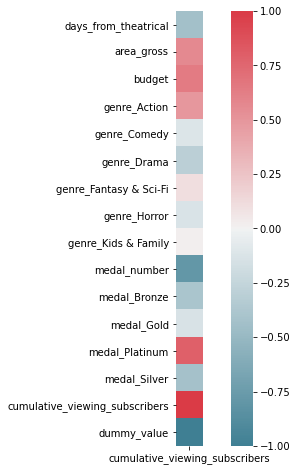

In [56]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [57]:
TARGET_COL = ['log_cumulative_viewing_subs'] # cumulative_first_views

In [58]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,log_cumulative_viewing_subs
dummy_value,-1.00
medal_number,-0.69
medal_Bronze,-0.41
days_from_theatrical,-0.40
medal_Silver,-0.39
genre_Comedy,-0.29
genre_Drama,-0.26
genre_Horror,0.02
genre_Kids & Family,0.06
medal_Gold,0.07


<AxesSubplot:>

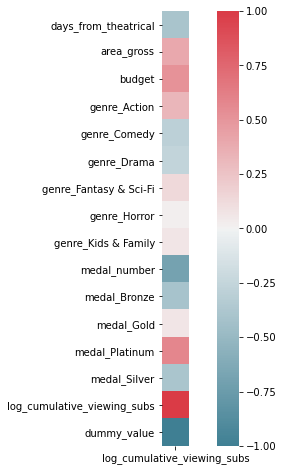

In [59]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [60]:
TARGET_COL = ['log_cumulative_first_views']

In [61]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,log_cumulative_first_views
dummy_value,-1.00
medal_number,-0.80
medal_Silver,-0.48
medal_Bronze,-0.47
days_from_theatrical,-0.43
genre_Drama,-0.37
genre_Comedy,-0.27
genre_Horror,-0.01
medal_Gold,0.13
genre_Kids & Family,0.18


<AxesSubplot:>

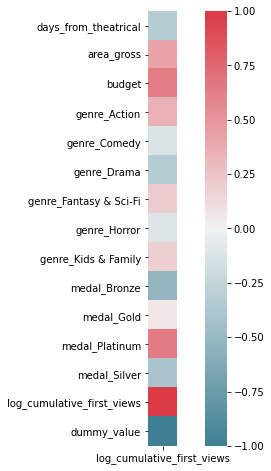

In [91]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [92]:
TARGET_COL = ['cumulative_first_views'] # cumulative_first_views

In [93]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,cumulative_first_views
dummy_value,-1.00
medal_Silver,-0.38
genre_Drama,-0.27
medal_Bronze,-0.26
days_from_theatrical,-0.25
genre_Horror,-0.17
genre_Comedy,-0.12
medal_Gold,-0.11
genre_Kids & Family,0.14
genre_Fantasy & Sci-Fi,0.22


<AxesSubplot:>

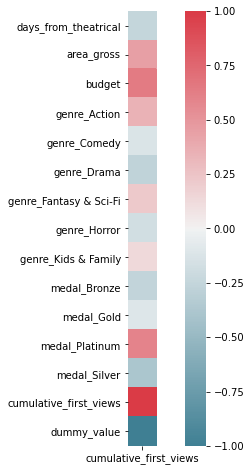

In [94]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

## Only movies after launch

In [51]:
data = movie_hbo[movie_hbo['days_from_max_launch'] < 0].copy()

In [52]:
data['pct_actives'] = data['pct_actives'].astype(float)

In [53]:
data.title_id.count()

72

In [54]:
TARGET_COL = ['cumulative_viewing_subs'] # cumulative_first_views

In [55]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,cumulative_viewing_subs
dummy_value,-1.00
medal_number,-0.55
days_from_theatrical2,-0.54
medal_Bronze,-0.38
genre_Drama,-0.27
genre_Comedy,-0.19
medal_Silver,-0.19
genre_Horror,-0.13
genre_Sci-Fi,-0.11
genre_Suspense/Thriller,-0.08


<AxesSubplot:>

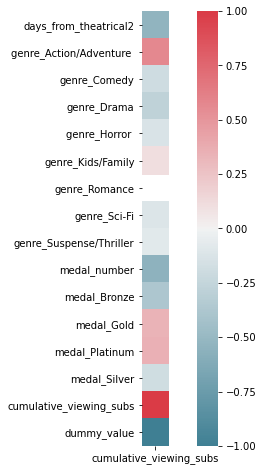

In [56]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [128]:
TARGET_COL = ['log_cumulative_first_views']

In [129]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
# corr.sort_values(by = TARGET_COL)

<AxesSubplot:>

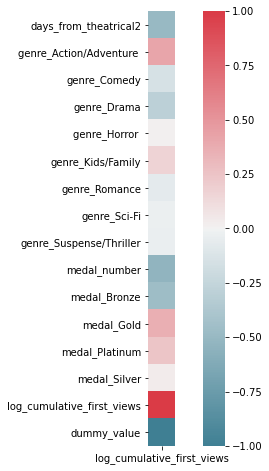

In [130]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [131]:
TARGET_COL = ['cumulative_first_views'] # cumulative_first_views

In [130]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,cumulative_first_views
dummy_value,-1.00
medal_number,-0.68
medal_Bronze,-0.46
budget,-0.31
area_gross,-0.27
days_from_theatrical,-0.19
genre_horror,-0.12
genre_action,-0.11
medal_Silver,-0.08
genre_fantasy & sci-fi,-0.07


<AxesSubplot:>

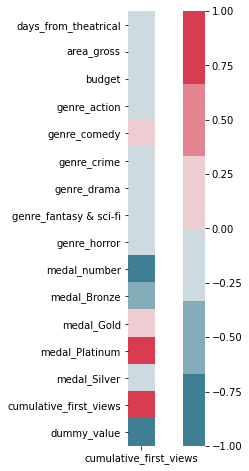

In [131]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 8, as_cmap=False),
            square=True, ax=ax)

### correlation between features

In [95]:
# FEATURE_COLS = ['days_from_theatrical','area_gross','budget',
#  'genre_action',
#  'genre_comedy',
#  'genre_crime',
#  'genre_drama',
#  'genre_fantasy & sci-fi',
#  'genre_horror',
#  'medal_number',
#  'is_direct_to_max_title']

In [96]:
plot_data=data[FEATURE_COLS]
corr = plot_data.corr()
mask=np.zeros_like(corr, dtype=np.bool)

<AxesSubplot:>

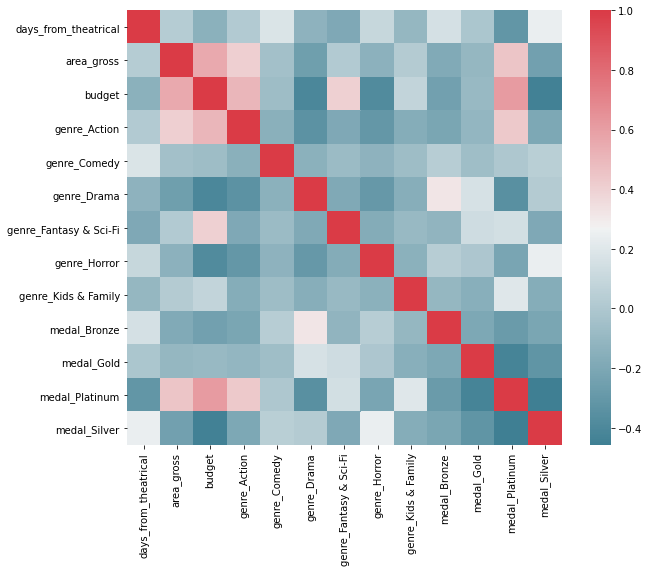

In [97]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [48]:
movie_hbo.to_csv('latam_training_data.csv')